<a href="https://colab.research.google.com/github/Meder11/Portfolio/blob/main/ab_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
ab_df = pd.read_csv("ab_dataset.csv")

In [6]:
 # Parse date
ab_df["date"] = pd.to_datetime(ab_df["date"])

/tmp/ipython-input-3968783937.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ab_df["date"] = pd.to_datetime(ab_df["date"])


In [7]:
# Basic sanity checks
print(ab_df.head())
print(ab_df.groupby("variant")["converted"].agg(["mean", "count", "sum"]))

   user_id       date variant  converted   device  session_duration_seconds  \
0        1 2025-09-28       A          0  desktop                        72   
1        2 2025-09-10       B          0   mobile                        68   
2        3 2025-09-19       B          0   mobile                        28   
3        4 2025-09-24       B          0  desktop                        46   
4        5 2025-09-13       A          0   mobile                        32   

   pages_viewed traffic_source country  
0             5       Facebook  Brazil  
1             2     Google Ads   India  
2             4     Google Ads      UK  
3             2     Google Ads      US  
4             5     Google Ads      US  
             mean  count  sum
variant                      
A        0.032161  10012  322
B        0.042451   9988  424


In [8]:
# Two-proportion z-test (conversion rate A vs B)
summary = ab_df.groupby("variant")["converted"].agg(["mean", "count", "sum"]).reset_index()

conv_A = summary.loc[summary["variant"] == "A", "sum"].iloc[0]
conv_B = summary.loc[summary["variant"] == "B", "sum"].iloc[0]

n_A = summary.loc[summary["variant"] == "A", "count"].iloc[0]
n_B = summary.loc[summary["variant"] == "B", "count"].iloc[0]

p_A = conv_A / n_A
p_B = conv_B / n_B

p_pool = (conv_A + conv_B) / (n_A + n_B)
se = np.sqrt(p_pool * (1 - p_pool) * (1.0 / n_A + 1.0 / n_B))
z_score = (p_B - p_A) / se
p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))

print("p_A:", p_A)
print("p_B:", p_B)
print("z_score:", z_score)
print("p_value:", p_value)

p_A: 0.03216140631242509
p_B: 0.04245094112935523
z_score: 3.8395517788131284
p_value: 0.00012325913291832968


In [9]:
# 95% CI for difference in proportions (B - A)
se_diff = np.sqrt(p_A * (1 - p_A) / n_A + p_B * (1 - p_B) / n_B)
diff = p_B - p_A
ci_low = diff - 1.96 * se_diff
ci_high = diff + 1.96 * se_diff

print("diff:", diff)
print("95_CI_low:", ci_low)
print("95_CI_high:", ci_high)

diff: 0.010289534816930138
95_CI_low: 0.005038071936496834
95_CI_high: 0.015540997697363442


In [10]:
# t-test on engagement metric (session_duration_seconds)

A_dur = ab_df.loc[ab_df["variant"] == "A", "session_duration_seconds"]
B_dur = ab_df.loc[ab_df["variant"] == "B", "session_duration_seconds"]

t_stat, t_p = stats.ttest_ind(B_dur, A_dur, equal_var=False)
print("t_stat_dur:", t_stat)
print("p_value_dur:", t_p)

t_stat_dur: 2.290974757791625
p_value_dur: 0.02197522790031966


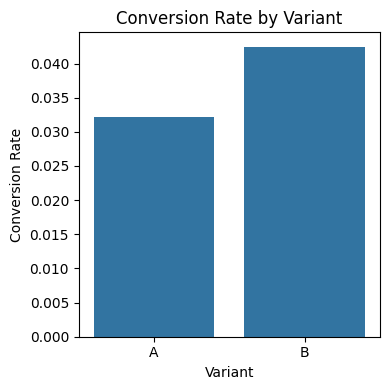

In [11]:
# Conversion rate by variant (barplot)
conv_by_variant = ab_df.groupby("variant")["converted"].mean().reset_index()

plt.figure(figsize=(4, 4))
sns.barplot(data=conv_by_variant, x="variant", y="converted")
plt.title("Conversion Rate by Variant")
plt.ylabel("Conversion Rate")
plt.xlabel("Variant")
plt.tight_layout()
plt.show()

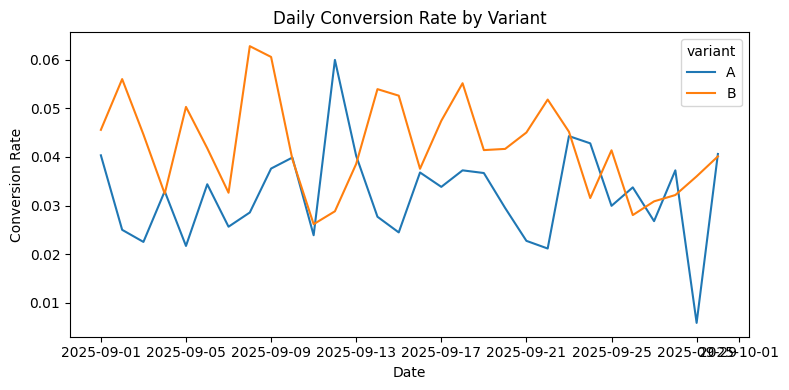

In [12]:
# Daily conversion rate by variant (lineplot)
conv_daily = (
    ab_df.groupby(["date", "variant"])["converted"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 4))
sns.lineplot(data=conv_daily, x="date", y="converted", hue="variant")
plt.title("Daily Conversion Rate by Variant")
plt.ylabel("Conversion Rate")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

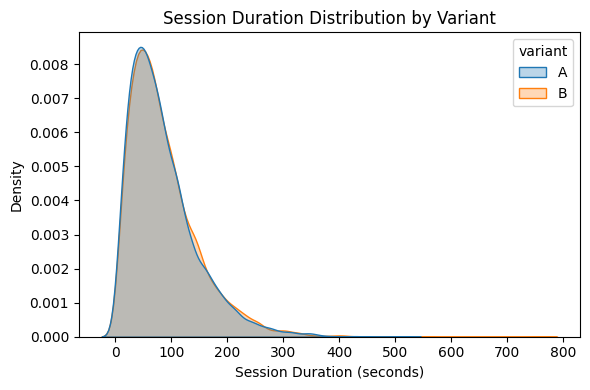

In [13]:
# distribution of session duration by variant
plt.figure(figsize=(6, 4))
sns.kdeplot(
    data=ab_df,
    x="session_duration_seconds",
    hue="variant",
    common_norm=False,
    fill=True,
    alpha=0.3
)
plt.title("Session Duration Distribution by Variant")
plt.xlabel("Session Duration (seconds)")
plt.tight_layout()
plt.show()